# 实验七：GARCH模型分析与实现

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model # 专门用于估计ARCH/GARCH类模型的库
from statsmodels.stats.diagnostic import het_arch #  用于进行ARCH效应检验

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False  

In [2]:
# 读取CSV文件，只选择第2列和第6列（交易日期和收盘价）
data = pd.read_csv('../../实验七/assets/data/1LShowData_SSEC_daily.csv', encoding='gbk', usecols=[2, 6])
data

,交易日期,收盘
0,1997/1/2,919.44
1,1997/1/3,899.61
2,1997/1/6,876.50
3,1997/1/7,898.17
4,1997/1/8,896.41
...,...,...
5086,2017/12/29,3307.17
5087,2018/1/2,3348.33
5088,2018/1/3,3369.11
5089,2018/1/4,3385.71


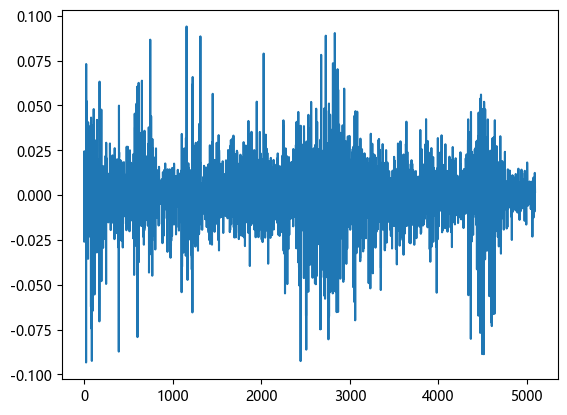

In [3]:
# 将列名重命名为英文，便于处理
data.columns = ['date', 'close']

# 计算对数收益率
r = np.log(data['close']) - np.log(data['close'].shift())
r = r[np.isfinite(r)]

# 绘制收益率时间序列图
plt.plot(r)

建立并拟合标准GARCH(1,1)模型

**解释**：
- 构建GARCH(1,1)模型，其中：
  - `mean='constant'`：均值模型为常数
  - `vol='garch'`：波动率模型为GARCH
  - `p=1, q=1`：GARCH项和ARCH项的阶数均为1
  - `dist='normal'`：假设残差服从正态分布

GARCH(1,1)模型可以表示为：

$$r_t = \mu + \varepsilon_t$$
$$\varepsilon_t = \sigma_t z_t, \quad z_t \sim N(0,1)$$
$$\sigma_t^2 = \omega + \alpha \varepsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

其中：
- $r_t$是收益率
- $\mu$是均值（常数）
- $\varepsilon_t$是残差
- $\sigma_t^2$是条件方差
- $\omega$是常数项
- $\alpha$是ARCH项系数（表示过去震荡对当前波动率的影响）
- $\beta$是GARCH项系数（表示波动率的持续性）

模型结果显示：
- $\mu \approx 0.00022$
- $\omega \approx 5.29 \times 10^{-6}$
- $\alpha \approx 0.10$
- $\beta \approx 0.88$

注意到$\alpha + \beta = 0.98 < 1$，满足GARCH模型的平稳性条件。系数$\beta$较大表明波动率具有较强的持续性。

In [4]:
# mu常数，波动率 GARCH(1, 1)，分布 正态
am_garch = arch_model(r, mean='constant', vol='garch', p=1, q=1, dist='normal') 
res_garch = am_garch.fit()
print(res_garch.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1430893525100.7856
Iteration:      2,   Func. Count:     18,   Neg. LLF: -14474.835667164152
Optimization terminated successfully    (Exit mode 0)
            Current function value: -14474.835659373894
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                14474.8
Distribution:                  Normal   AIC:                          -28941.7
Method:            Maximum Likelihood   BIC:                          -28915.5
                                        No. Observations:                 5090
Date:                Sat, Apr 19 2025   Df Residuals:                     5089
Time:       

d:\anaconda\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002644. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


建立并拟合AR(1)-GARCH(1,1)模型

**解释**：
- 构建AR(1)-GARCH(1,1)模型，即在前一个模型基础上，将均值模型由常数改为AR(1)过程
- `mean='ar', lags=1`：均值模型为1阶自回归过程

AR(1)-GARCH(1,1)模型可以表示为：

$$r_t = \mu + \phi r_{t-1} + \varepsilon_t$$
$$\varepsilon_t = \sigma_t z_t, \quad z_t \sim N(0,1)$$
$$\sigma_t^2 = \omega + \alpha \varepsilon_{t-1}^2 + \beta \sigma_{t-1}^2$$

其中$\phi$是AR(1)过程的系数，表示收益率的自相关性。

模型结果显示：
- $\mu \approx 0.00022$
- $\phi \approx 0.011$（P值为0.472，不显著）
- $\omega, \alpha, \beta$与之前接近

AR项的系数不显著，说明股票收益率不存在明显的自相关性，这与有效市场假说一致。

In [5]:
# 均值为AR(1)过程，波动率模型为GARCH(1,1)，服从正态分布
am_ar_garch = arch_model(r, mean='ar', lags=1, vol='garch', p=1, q=1, dist='normal')
res_am_ar_garch = am_ar_garch.fit()
print(res_am_ar_garch.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 887808777512.9001
Iteration:      2,   Func. Count:     20,   Neg. LLF: -14472.862358762399
Optimization terminated successfully    (Exit mode 0)
            Current function value: -14472.862350988773
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2
                           AR - GARCH Model Results                           
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                14472.9
Distribution:                  Normal   AIC:                          -28935.7
Method:            Maximum Likelihood   BIC:                          -28903.1
                                        No. Observations:                 5089
Date:                Sat, Apr 19 2025   Df Residuals:                     5087
Time:        

d:\anaconda\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002643. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


模拟GARCH(1,1)过程

**解释**：
- 使用指定参数模拟GARCH(1,1)过程
- 设置的参数为：
  - $\mu = 0.0006$
  - $\omega = 0.00008$
  - $\alpha = 0.15$
  - $\beta = 0.8$

- 模拟1000个观测值，并绘图展示

模拟GARCH过程有助于理解波动率聚集（volatility clustering）现象，即金融市场中大波动往往跟随大波动，小波动跟随小波动的特征。

mu          0.000222
omega       0.000005
alpha[1]    0.100000
beta[1]     0.880000
Name: params, dtype: float64


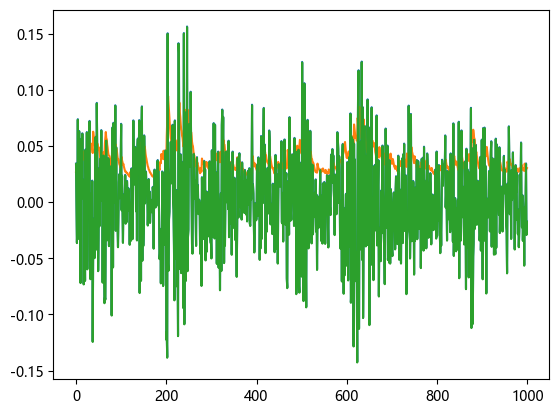

In [6]:
# 创建模拟用的GARCH模型
sim_garch = arch_model(None, mean='constant', vol='garch', dist='normal', p=1, q=1)
print(res_garch.params)

# 设置模拟参数
sim_paras = pd.Series([0.0006, 0.00008, 0.15, 0.8], index=['mu', 'omega', 'alpha[1]', 'beta[1]'])

# 模拟1000个观测值
sim_garch_data = sim_garch.simulate(sim_paras, 1000)

# 绘制模拟结果
plt.plot(sim_garch_data)

建立并拟合EGARCH(1,1,1)模型

**解释**：
- 构建EGARCH(1,1,1)模型
- `r*100`：将收益率放大100倍，这是为了解决之前警告中提到的数据尺度问题
- `vol='egarch'`：使用指数GARCH模型
- `p=1, q=1, o=1`：GARCH项、ARCH项和非对称项的阶数均为1

EGARCH模型考虑了收益率变化的非对称效应（即负向冲击对波动率的影响可能大于正向冲击），可以表示为：

$$\ln(\sigma_t^2) = \omega + \beta \ln(\sigma_{t-1}^2) + \alpha [|z_{t-1}| - E(|z_{t-1}|)] + \gamma z_{t-1}$$

其中：
- $\ln(\sigma_t^2)$是条件方差的对数
- $z_t = \varepsilon_t / \sigma_t$是标准化残差
- $\gamma$是杠杆效应参数，用于捕捉非对称性

模型结果显示：
- $\mu \approx 0.0145$（注意单位变化）
- $\omega \approx 0.0181$
- $\alpha \approx 0.1737$
- $\gamma \approx -0.0232$（显著为负，表明存在杠杆效应）
- $\beta \approx 0.9886$

$\gamma$显著为负说明负向冲击（比如股价下跌）会导致更高的波动率，这符合金融市场中常见的"杠杆效应"。

In [7]:
# 乘以100是为了改善数值优化的尺度
am_egarch = arch_model(r*100, mean='constant', vol='egarch', p=1, q=1, o=1)
res_egarch = am_egarch.fit()
print(res_egarch.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 41310.24007067039
Iteration:      2,   Func. Count:     20,   Neg. LLF: 41311.930866633185
Iteration:      3,   Func. Count:     31,   Neg. LLF: 1053056504.8062321
Iteration:      4,   Func. Count:     41,   Neg. LLF: 9326.272080588187
Iteration:      5,   Func. Count:     49,   Neg. LLF: 69534.02742630933
Iteration:      6,   Func. Count:     57,   Neg. LLF: 8932.101523765676
Iteration:      7,   Func. Count:     64,   Neg. LLF: 9020.736319561376
Iteration:      8,   Func. Count:     72,   Neg. LLF: 8930.874073790517
Iteration:      9,   Func. Count:     79,   Neg. LLF: 8907.632705122136
Iteration:     10,   Func. Count:     85,   Neg. LLF: 8907.626055527973
Iteration:     11,   Func. Count:     91,   Neg. LLF: 8907.625999106054
Iteration:     12,   Func. Count:     97,   Neg. LLF: 8907.626001698038
Iteration:     13,   Func. Count:    104,   Neg. LLF: 8907.625987108073
Iteration:     14,   Func. Count:    109,   Neg. LLF: 8907.625

ARCH效应检验

**解释**：
- 使用`het_arch`函数对收益率序列进行ARCH效应检验
- `nlags=10`表示检验滞后10期的ARCH效应

ARCH效应检验的原假设是：收益率序列不存在ARCH效应，即残差的平方不存在自相关性。

检验结果为$(452.03, 7.71 \times 10^{-91}, 49.51, 2.90 \times 10^{-95})$，包含：
- LM检验统计量
- LM检验的p值
- F检验统计量
- F检验的p值

极小的p值表明我们可以强烈拒绝原假设，即收益率序列确实存在显著的ARCH效应，证明使用GARCH类模型是合适的。

In [8]:
# 进行ARCH效应检验
result_arch_test = het_arch(r, nlags=10)
print(result_arch_test)

(452.0287706945431, 7.713522349291788e-91, 49.51054630896035, 2.899662510623906e-95)
